In [1]:
!pip install tensorflow
!pip install keras
!pip install imblearn
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tensorflow-addons

## **Import Libraries**

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np

#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from tensorflow.keras.callbacks import Callback


#   Optimizer
from tensorflow.keras.optimizers import SGD

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Convolution2D, ReLU, AveragePooling2D, Dropout, Flatten, Dense, Softmax
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **Dataset**

In [3]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "/Dataset"

##  Name of classes
CLASSES = ['Mild_Demented',
           'Moderate_Demented',
           'Non_Demented',
           'Very_Mild_Demented']

**Load using DataGenerator**

In [4]:
X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(150, 150),batch_size=6400, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 6400 images belonging to 4 classes.


In [5]:
#   Number of samples in classes
from collections import Counter
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

#   class labels as per indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 896), (1, 64), (2, 3200), (3, 2240)]
Classes Names according to index:	 {'Mild_Demented': 0, 'Moderate_Demented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}


## **Split into Train, Test, Val Set**

In [6]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 620), (1, 46), (2, 2242), (3, 1572)]
Validation	 [(0, 226), (1, 16), (2, 769), (3, 525)]
Test      	 [(0, 50), (1, 2), (2, 189), (3, 143)]


In [7]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (4480, 150, 150, 3)
y_train shape: (4480, 4)
X_val shape: (1536, 150, 150, 3)
y_val shape: (1536, 4)


## **Define CNN**

In [8]:
# Define a function to create the CNN model
def create_cnn_model(input_shape=(150, 150, 3)):
    seed_value = 42
  # Define the initializer
    init = glorot_uniform(seed=seed_value)
    model = Sequential()

    model.add(Input(shape=input_shape))

    model.add(Convolution2D(16, 5, kernel_initializer=init))
    model.add(ReLU())
    model.add(AveragePooling2D(pool_size=(2,2)))

    model.add(Convolution2D(32, 5, kernel_initializer=init))
    model.add(ReLU())
    model.add(AveragePooling2D(pool_size=(2,2)))

    model.add(Convolution2D(64, 5, kernel_initializer=init))
    model.add(ReLU())
    model.add(AveragePooling2D(pool_size=(2,2)))

    model.add(Convolution2D(128, 5, kernel_initializer=init))
    model.add(ReLU())
    model.add(AveragePooling2D(pool_size=(2,2)))


    model.add(Dropout(0.01))

    model.add(Flatten())

    model.add(Dense(256, kernel_initializer=init))
    model.add(ReLU())
    model.add(Dropout(0.03))

    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## **Define ResNet50**

In [9]:
def create_resnet_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])

    # Use a lower learning rate
    optimizer = SGD(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## **Training and Ploting**

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to train and plot accuracy
def train_and_plot(model, X_train, y_train, X_val, y_val, epochs=50):

    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)
    # Calculate and plot confusion matrix
    y_pred = np.argmax(model.predict(X_val), axis=1)
    y_true = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, classes=['MILD_DEMENTED', 'MODERATE_DEMENTED', 'NON_DEMENTED', 'VERY_MILD_DEMENTED'])
    plt.show()

    # Plot training history
    plot_training_history(history)


def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('history_plot.png')
    plt.show()


    plt.tight_layout()


def plot_confusion_matrix(cm, classes, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [11]:
# Input shape 
input_shape = ( 150, 150, 3)

**CNN Model Summary**

In [12]:
# Create CNN model
cnn_model = create_cnn_model(input_shape)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 16)      1216      
                                                                 
 re_lu (ReLU)                (None, 146, 146, 16)      0         
                                                                 
 average_pooling2d (Average  (None, 73, 73, 16)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 32)        12832     
                                                                 
 re_lu_1 (ReLU)              (None, 69, 69, 32)        0         
                                                                 
 average_pooling2d_1 (Avera  (None, 34, 34, 32)        0         
 gePooling2D)                                           

**ResNet Model Summary**

In [13]:
# Create ResNet model
resnet_model = create_resnet_model(input_shape)
resnet_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               

In [14]:
# Set up TensorFlow to use GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


## **Train and Plot CNN**

Epoch 1/50


2023-12-01 18:16:49.828918: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


140/140 - 15s - loss: 1.0328 - accuracy: 0.5031 - val_loss: 1.0163 - val_accuracy: 0.4993 - 15s/epoch - 106ms/step
Epoch 2/50
140/140 - 3s - loss: 1.0018 - accuracy: 0.5076 - val_loss: 1.0260 - val_accuracy: 0.5072 - 3s/epoch - 21ms/step
Epoch 3/50
140/140 - 3s - loss: 0.9903 - accuracy: 0.5241 - val_loss: 0.9834 - val_accuracy: 0.5046 - 3s/epoch - 21ms/step
Epoch 4/50
140/140 - 3s - loss: 0.9777 - accuracy: 0.5270 - val_loss: 0.9659 - val_accuracy: 0.5078 - 3s/epoch - 21ms/step
Epoch 5/50
140/140 - 3s - loss: 0.9711 - accuracy: 0.5237 - val_loss: 0.9957 - val_accuracy: 0.5221 - 3s/epoch - 21ms/step
Epoch 6/50
140/140 - 3s - loss: 0.9561 - accuracy: 0.5254 - val_loss: 0.9922 - val_accuracy: 0.5208 - 3s/epoch - 21ms/step
Epoch 7/50
140/140 - 3s - loss: 0.9510 - accuracy: 0.5308 - val_loss: 1.0182 - val_accuracy: 0.5026 - 3s/epoch - 21ms/step
Epoch 8/50
140/140 - 3s - loss: 0.9465 - accuracy: 0.5388 - val_loss: 0.9958 - val_accuracy: 0.5046 - 3s/epoch - 21ms/step
Epoch 9/50
140/140 - 3s 

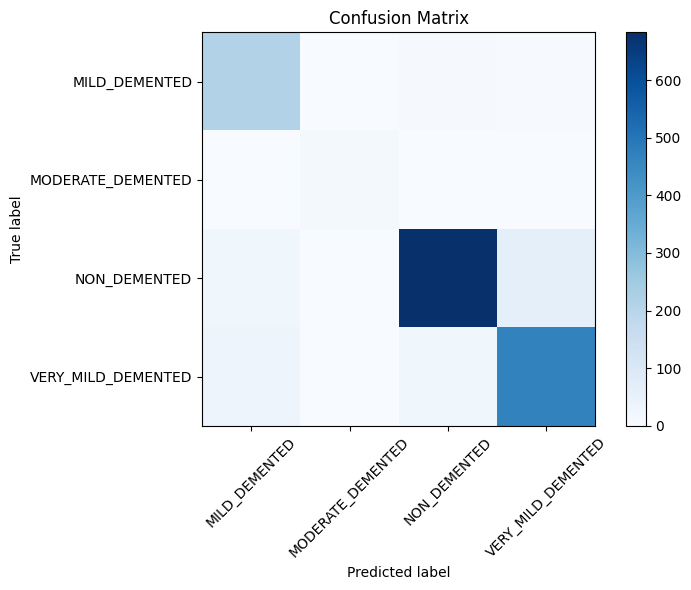

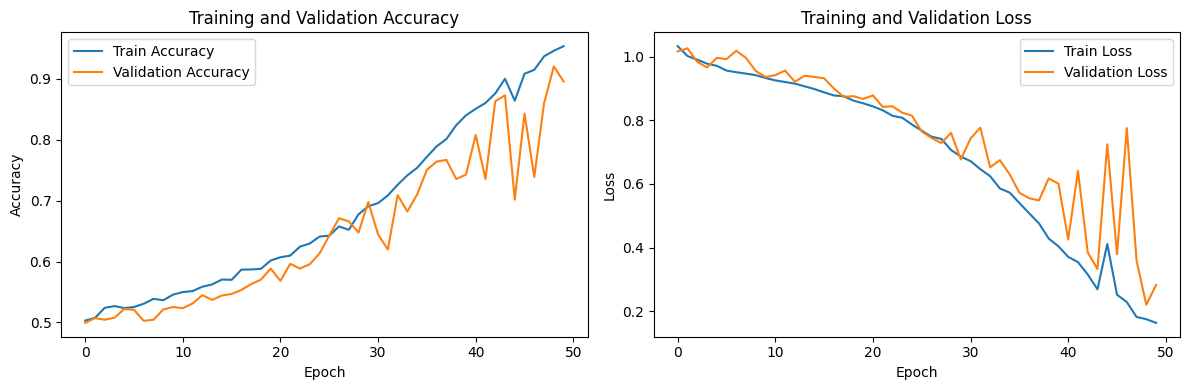

<Figure size 640x480 with 0 Axes>

In [15]:
train_and_plot(cnn_model, X_train, y_train, X_val, y_val)

## **Train and Plot ResNet**

Epoch 1/50
140/140 - 16s - loss: 1.5003 - accuracy: 0.2998 - val_loss: 1.2810 - val_accuracy: 0.5007 - 16s/epoch - 116ms/step
Epoch 2/50
140/140 - 10s - loss: 1.3226 - accuracy: 0.3569 - val_loss: 1.2408 - val_accuracy: 0.5007 - 10s/epoch - 70ms/step
Epoch 3/50
140/140 - 10s - loss: 1.2776 - accuracy: 0.3984 - val_loss: 1.2148 - val_accuracy: 0.5007 - 10s/epoch - 70ms/step
Epoch 4/50
140/140 - 10s - loss: 1.2516 - accuracy: 0.4290 - val_loss: 1.1804 - val_accuracy: 0.5007 - 10s/epoch - 70ms/step
Epoch 5/50
140/140 - 10s - loss: 1.2172 - accuracy: 0.4357 - val_loss: 1.1692 - val_accuracy: 0.5007 - 10s/epoch - 70ms/step
Epoch 6/50
140/140 - 10s - loss: 1.2037 - accuracy: 0.4444 - val_loss: 1.1538 - val_accuracy: 0.5007 - 10s/epoch - 69ms/step
Epoch 7/50
140/140 - 10s - loss: 1.1921 - accuracy: 0.4585 - val_loss: 1.1342 - val_accuracy: 0.5007 - 10s/epoch - 69ms/step
Epoch 8/50
140/140 - 10s - loss: 1.1795 - accuracy: 0.4728 - val_loss: 1.1328 - val_accuracy: 0.5007 - 10s/epoch - 69ms/step

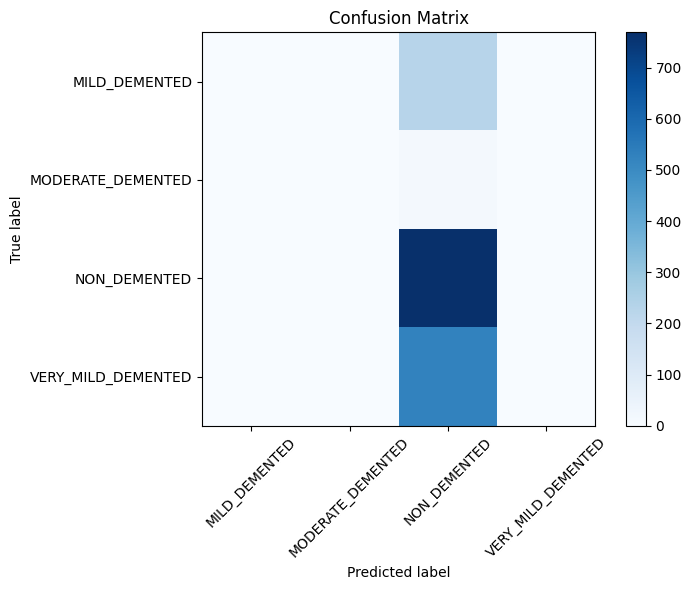

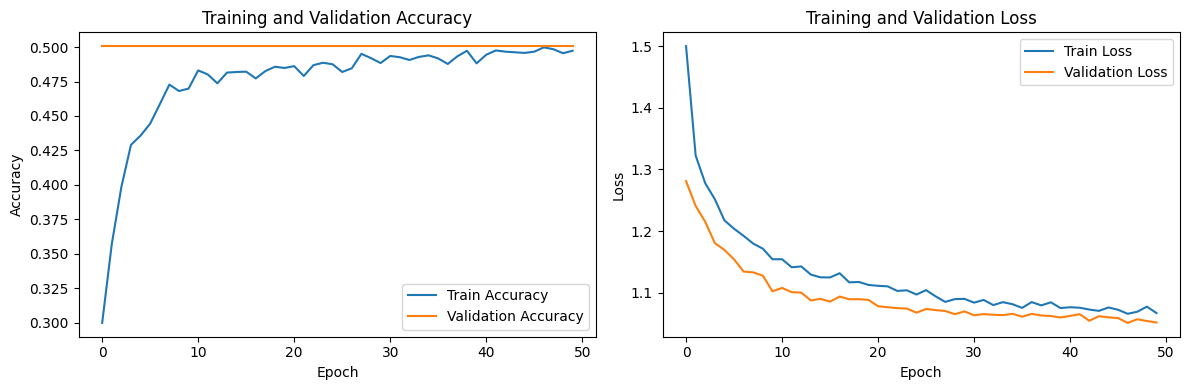

<Figure size 640x480 with 0 Axes>

In [16]:
train_and_plot(resnet_model, X_train, y_train, X_val, y_val)